In [1]:

!pip install pyspark

In [ ]:
# Mount google drive
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive/', force_remount=True)

In [ ]:
import os
base_dir = '/content/drive/MyDrive/IDS561_ProjectData/'
os.chdir(base_dir)
os.listdir()

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand 
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('IDS561_Project_sql').getOrCreate()
imdb_df=spark.read.csv('IMDB Dataset.csv',
                         sep=',',
                         header=True,
                         quote='"',
                         encoding='utf-8',
                         escape='"',
                         multiLine=True).\
                         select(
                             'review',
                             'sentiment'                             
                             )

In [10]:
print(imdb_df.count())
imdb_df.show(5)
imdb_df.printSchema()

50000
+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...| positive|
|A wonderful littl...| positive|
|I thought this wa...| positive|
|Basically there's...| negative|
|Petter Mattei's "...| positive|
+--------------------+---------+
only showing top 5 rows

root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [11]:
imdb_df = imdb_df.withColumnRenamed("sentiment","label")
imdb_df.show(5)

+--------------------+--------+
|              review|   label|
+--------------------+--------+
|One of the other ...|positive|
|A wonderful littl...|positive|
|I thought this wa...|positive|
|Basically there's...|negative|
|Petter Mattei's "...|positive|
+--------------------+--------+
only showing top 5 rows



In [12]:
# convert String labels to int type
import pyspark.sql.functions as F

imdb_df = imdb_df.withColumn('label', F.when(imdb_df.label == 'negative', 0).otherwise(1))


In [7]:
imdb_df.groupby('label').count().toPandas()

,label,count
0,1,25000
1,0,25000


In [ ]:
# Validating if null values in each column
data_agg = imdb_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in imdb_df.columns])
data_agg.show()

In [ ]:
imdb_df.toPandas()['review'].isnull().sum()
imdb_df.toPandas()['label'].isnull().sum()

In [13]:
# convert the distinct labels in the input dataset to index values
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(imdb_df)
# tokenizer 
tokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\W")##'\w' remove none-word letters
df_tokenized = tokenizer.transform(imdb_df)
# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_removed = remover.transform(df_tokenized)
# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)

Row(features=SparseVector(262144, {2325: 3.1114, 3280: 13.108, 4367: 6.6609, 6957: 3.2463, 9129: 4.6852, 9781: 2.1362, 10345: 4.4414, 13041: 5.9756, 13130: 4.4229, 13266: 9.4335, 17893: 2.7926, 20376: 5.5315, 21570: 2.9565, 21732: 4.3966, 21823: 0.5639, 21894: 3.3662, 23071: 2.1615, 24031: 6.7746, 25964: 2.4796, 29066: 3.299, 29926: 9.7212, 32070: 5.1499, 35091: 5.7384, 36547: 6.0491, 40299: 2.8936, 43333: 3.9793, 44484: 4.4637, 46762: 13.4719, 47959: 7.1062, 52889: 5.2515, 55875: 3.2224, 59830: 10.428, 60824: 6.8201, 62058: 2.5572, 63139: 3.7625, 63746: 4.2131, 64465: 4.1839, 65492: 12.9007, 66187: 5.7139, 70065: 1.8954, 70292: 3.8213, 70546: 8.7404, 73018: 10.8247, 77161: 6.389, 77645: 2.5091, 77971: 5.4679, 91192: 2.2396, 92032: 3.9374, 92064: 4.7537, 92159: 3.2264, 92651: 2.6459, 97514: 5.9071, 97799: 4.1618, 98586: 3.3697, 98717: 2.7602, 99580: 6.32, 101176: 5.1638, 101501: 6.7594, 101796: 5.1194, 102353: 4.7867, 102759: 6.8495, 106606: 9.7212, 107951: 8.6226, 113186: 4.2131, 1136

In [14]:
# Split data aproximately into training (80%) and test (20%)
(train, test)=imdb_df.randomSplit([0.8,0.2], seed = 0)
# Cache the train and test data in-memory 
train = train.cache()
test = test.cache()
print(("Sample number in the train set : {}").format(train.count()))
print(("Sample number in the test set : {}").format(test.count()))
train.groupby('label').count().toPandas()

Sample number in the train set : 39991
Sample number in the test set : 10009


,label,count
0,1,20037
1,0,19954


In [ ]:
# Logistic Regression

def grid_search(p1,p2,p3,p4):
    lr = LogisticRegression()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, lr])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(lr.regParam, [p2])
                 .addGrid(lr.elasticNetParam, [p3])
                 .addGrid(lr.maxIter, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    return average_score[0]

In [ ]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [0.09,0.10,0.11]:
        for p3 in [0.09,0.10,0.11]:
            for p4 in [9,10,11]:
                t0 = time()
                print(('(numFeatures,regParam,elasticNetParam,maxIter)=({},{},{},{})').format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print(("Classifier trained in {} seconds").format(round(tt,3)))
                if average_score > score:
                    print('################ Best score ######################')
                    params=(p1,p2,p3,p4)
                    score=average_score
print(('Best score is {} at params ={}').format(score, params))

In [15]:
def Data_modeling(train, test, pipeline, paramGrid):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    
    ########  Make predictions on on the test data
    prediction = cvModel.transform(test)
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    ######## Calculate accuracy of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy_score=evaluator.evaluate(prediction)
    print(('Accuracy in the test data = {}').format(accuracy_score))
    
    ######## F1 score of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score=evaluator.evaluate(prediction)
    print(('F1 score in the test data = {}').format(f1_score))
        
    ######## Print classification_report
    prediction_and_labels=prediction.select("label","prediction")
    y_true = []
    y_pred = []
    for x in prediction_and_labels.collect():
        xx = list(x)
        try:
            tt = int(xx[1])
            pp = int(xx[0])
            y_true.append(tt)
            y_pred.append(pp)
        except:
            continue

    target_names = ['neg 0', 'pos 1']
    print(classification_report(y_true, y_pred, target_names=target_names))
    return 

In [16]:
# Train by a Logistic regression Model
lr = LogisticRegression()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, lr])

# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(lr.regParam, [0.10])
             .addGrid(lr.elasticNetParam, [0.10])
             .addGrid(lr.maxIter, [10])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.8584972377077896
Accuracy in the test data = 0.8640223798581277
F1 score in the test data = 0.863783226165679
              precision    recall  f1-score   support

       neg 0       0.82      0.90      0.86      4583
       pos 1       0.91      0.83      0.87      5426

    accuracy                           0.86     10009
   macro avg       0.86      0.87      0.86     10009
weighted avg       0.87      0.86      0.86     10009



In [ ]:
def grid_search(p1,p2):
    nb = NaiveBayes()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, nb])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(nb.smoothing, [p2])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    return average_score[0]

In [ ]:
score=0.0
for p1 in [35000,40000,55000]:
    for p2 in [0.8,0.9,1.0]:
      t0 = time()
      print(('(numFeatures,smoothing)=({},{})').format(p1,p2))
      average_score=grid_search(p1,p2)
      tt = time() - t0
      print (("Classifier trained in {} seconds").format(round(tt,3)))
      if average_score > score:
        print('################ Best score ######################')
        params=(p1,p2)
        score=average_score
print(('Best score is {} at params ={}').format(score, params))

In [18]:
# trained by a Naïve Bayes 
nb = NaiveBayes()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, nb])
# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [40000])
             .addGrid(nb.smoothing, [1.0])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.8476583483211434
Accuracy in the test data = 0.8507343390948147
F1 score in the test data = 0.8507244290215308
              precision    recall  f1-score   support

       neg 0       0.86      0.85      0.85      5096
       pos 1       0.84      0.85      0.85      4913

    accuracy                           0.85     10009
   macro avg       0.85      0.85      0.85     10009
weighted avg       0.85      0.85      0.85     10009



In [ ]:
#Decision Tree
def grid_search(p1,p2,p3):
    # trained by a Decision Tree 
    dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, dt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(dt.maxDepth, [p2])
                 .addGrid(dt.minInstancesPerNode, [p3])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    return average_score[0]

In [ ]:
score=0.0
for p1 in [65000,70000,75000]:
    for p2 in [23,24,25,26,27]:
        for p3 in [3,4,5]:
          t0 = time()
          print(('(numFeatures,maxDepth,minInstancesPerNode)=({},{},{})').format(p1,p2,p3))
          average_score=grid_search(p1,p2,p3)
          tt = time() - t0
          print(("Classifier trained in {} seconds").format(round(tt,3)))
          if average_score > score:
            print('################ Best score ######################')
            params=(p1,p2,p3)
            score=average_score
print(('Best score is {} at params ={}').format(score, params))

In [11]:
# Train by Decision Tree Model
dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, dt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [70000])
             .addGrid(dt.maxDepth, [25])
             .addGrid(dt.minInstancesPerNode, [4])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7313386247372835
Accuracy in the test data = 0.7341392746528125
F1 score in the test data = 0.7337928303539383
              precision    recall  f1-score   support

       neg 0       0.70      0.76      0.73      4641
       pos 1       0.77      0.71      0.74      5368

    accuracy                           0.73     10009
   macro avg       0.73      0.74      0.73     10009
weighted avg       0.74      0.73      0.73     10009



In [ ]:
#RandomForest
def grid_search(p1,p2,p3,p4):
    rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, rf])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(rf.numTrees, [p2])
                 .addGrid(rf.maxDepth, [p3])
                 .addGrid(rf.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    return average_score[0]

In [ ]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [30,31,32]:
        for p3 in [28,29,30]:
            for p4 in [1,2]:
                t0 = time()
                print(('(numFeatures,numTrees,maxDepth,minInstancesPerNode)=({},{},{},{})').format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print(("Classifier trained in {} seconds").format(round(tt,3)))
                if average_score > score:
                  print('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=average_score
print(('Best score is {} at params ={}').format(score, params))
#Best score is 0.77096908939 at params =(50000, 31, 29, 1)

In [12]:
rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, rf])

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(rf.numTrees, [31])
             .addGrid(rf.maxDepth, [29])
             .addGrid(rf.minInstancesPerNode, [1])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.8250304458404724
Accuracy in the test data = 0.8272554700769308
F1 score in the test data = 0.8270403055276523
              precision    recall  f1-score   support

       neg 0       0.79      0.86      0.82      4649
       pos 1       0.87      0.80      0.83      5360

    accuracy                           0.83     10009
   macro avg       0.83      0.83      0.83     10009
weighted avg       0.83      0.83      0.83     10009



In [ ]:
#Gradient Boosting
def grid_search(p1,p2,p3,p4):
    gbt = GBTClassifier(labelCol="indexedLabel")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, gbt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(gbt.maxIter, [p2]) #(default: 20)
                 .addGrid(gbt.maxDepth, [p3])
                 .addGrid(gbt.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print(('average cross-validation accuracy = {}').format(average_score[0]))
    return average_score[0]




In [ ]:
score=0.0
for p1 in [60000]:
    for p2 in [25,26,27]:
        for p3 in [18,19,20]:
            for p4 in [2]:
                t0 = time()
                print(('(numFeatures,maxIter,maxDepth,minInstancesPerNode)=({},{},{},{})').format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print(("Classifier trained in {} seconds").format(round(tt,3)))
                if average_score > score:
                  print('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=(average_scoreprint 'Best score is {} at params ={}').format(score, params)

In [ ]:
# trained by a Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="indexedLabel")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, gbt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [60000])
             .addGrid(gbt.maxIter, [25]) #(default: 20)
             .addGrid(gbt.maxDepth, [19])
             .addGrid(gbt.minInstancesPerNode, [2])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

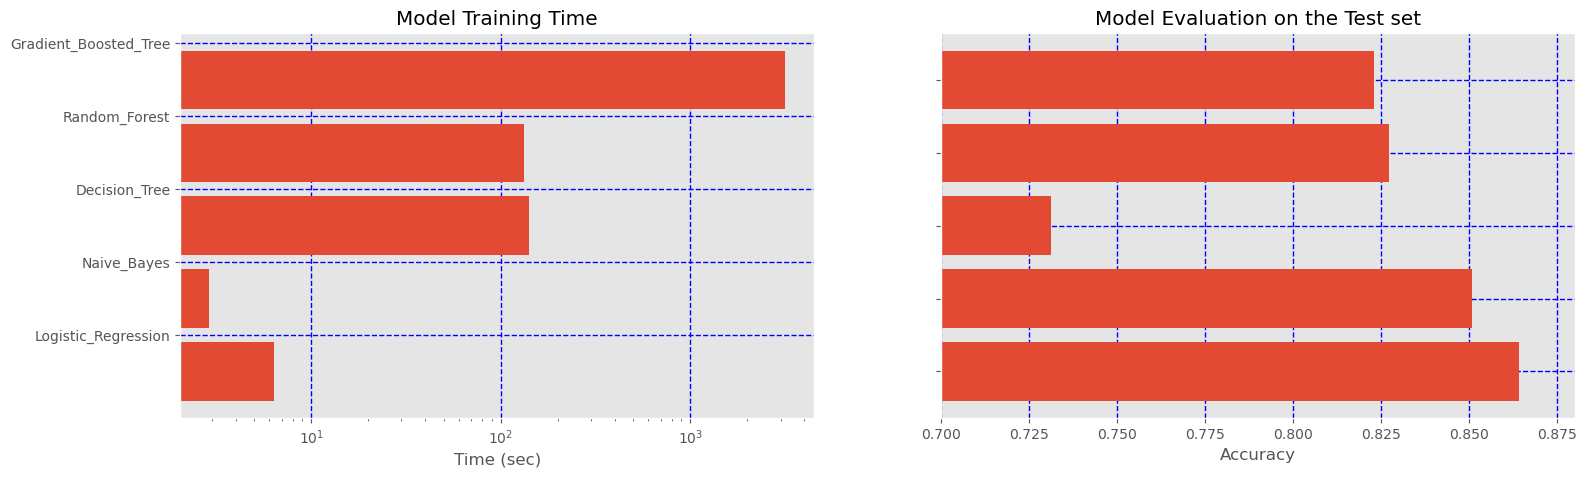

In [19]:
import matplotlib.pyplot as plt
import numpy as np
classifier_names=['Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest', 'Gradient_Boosted_Tree']
time=[6.41,2.893,141,133,3179]
accuracy=[0.86402,0.8507,0.7313,0.8272,0.8229]
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5), facecolor='white')
ax[0].barh(np.arange(0, 5),time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='b', linestyle='--', linewidth=1)
ax[0].set_title('Model Training Time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')

ax[1].barh(range(0, len(classifier_names)),accuracy)
ax[1].set_xlim([0.70,0.88])
ax[1].set_title('Model Evaluation on the Test set')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)